# GPU Computing with [CuPy](https://cupy.chainer.org/)

## CuPy in a Nutshell

* CuPy is a matrix library accelerated with [NVIDIA CUDA](https://developer.nvidia.com/cuda-zone). Using [CUDA-related GPU-accelerated libraries](https://developer.nvidia.com/gpu-accelerated-libraries) (cuBLAS, cuDNN, cuRand, cuSolver, cuSPARSE, cuFFT, NCCL) it allows to take full advantage of the computing power of GPUs.
* CuPy's core component is the `cupy.ndarray` class which is highly compatible with `numpy.ndarray`.
* It supports most of the high level operations of `NumPy` arrays and allows to write user defined kernels to execute on the GPU.
* CuPy produces GPU kernels optimized for the shapes and dtypes of given arguments on the fly.

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
# cp.cuda.set_allocator(None) # You can disable CuPy memory pool with this 
%load_ext Cython

In [2]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def cupy_timer():
    start = cp.cuda.Event()
    end = cp.cuda.Event()
    start.record()
    yield
    end.record()
    end.synchronize()
    elapsed_time = cp.cuda.get_elapsed_time(start, end)
    print(f'Elapsed time: {elapsed_time} ms')
    

@contextmanager
def cpu_timer():
    start = default_timer()
    yield
    end = default_timer()
    print(f'Elapsed time: {(end - start) * 1000} ms')

## Creating CuPy arrays directly on the GPU

In [3]:
A = cp.zeros((1000, 1000))
print(f'Array A is of type: {type(A)}')

B = cp.array([[1, 2, 3], 
              [4, 5, 6]])

print(B)

Array A is of type: <class 'cupy._core.core.ndarray'>
[[1 2 3]
 [4 5 6]]


In [4]:
cp_rng = cp.random.default_rng()
B = cp_rng.random((1000, 1000))
mu = B.mean()
print(f'The mean value is: {mu}')
print(f'The type of mu is: {type(mu)}')

The mean value is: 0.4998513286749936
The type of mu is: <class 'cupy._core.core.ndarray'>


## Transferring Arrays from Host to Device

In [5]:
np_rng = np.random.default_rng()
A_cpu = np_rng.random((1000, 1000))
A_gpu = cp.array(A_cpu)
mu_cpu = A_cpu.mean()
mu_gpu = A_gpu.mean()
print(f'Mean using CPU: {mu_cpu}')
print(f'Mean using GPU: {mu_gpu}')

Mean using CPU: 0.5000367836745098
Mean using GPU: 0.5000367836745098


## Tranferring CuPy arrays to Host

Tranferring of CuPy arrays to host is performed using the `cupy.ndarrray.get` method or the `cupy.asnumpy` function. 

In [6]:
x_gpu = cp.ones((1000, 1000))
x_cpu = x_gpu.get()
print(f'Type of CPU array is: {type(x_cpu)}')

Type of CPU array is: <class 'numpy.ndarray'>


In [ ]:
y_gpu = cp_rng.random((1000, 1000))
y_cpu = cp.asnumpy(y_gpu)
print(f'Type of CPU array is: {type(y_cpu)}')

## Typical CuPy Matrix Operations

### Matrix-Matrix Multiplication

In [8]:
x_cpu = np_rng.random((1000, 1000))
y_cpu = np_rng.random((1000, 1000))
x_gpu = cp.array(x_cpu)
y_gpu = cp.array(y_cpu)

with cpu_timer():
    z_cpu = x_cpu @ y_cpu

with cupy_timer():
    z_gpu = x_gpu @ y_gpu

Elapsed time: 6.541643990203738 ms
Elapsed time: 0.7004160284996033 ms


## Linear System Solving NumPy vs CuPy

In [10]:
A_cpu = np_rng.random((10000, 10000))
b_cpu = np_rng.random(10000)
A_gpu = cp.array(A_cpu)
b_gpu = cp.array(b_cpu)
with cpu_timer():
    np.linalg.solve(A_cpu, b_cpu)
    
with cupy_timer():
    cp.linalg.solve(A_gpu, b_gpu)

Elapsed time: 3842.4936721567065 ms
Elapsed time: 362.1820983886719 ms


## Euclidean distance matrix

$
    d_e(\mathbf x, \mathbf y) =
    \begin{bmatrix}
    \sum_{i=1}^n (x_{1i}-y_{1i})^2 & \sum_{i=1}^n(x_{1i}-y_{2i})^2 & \cdots & \sum_{i=1}^n (x_{1i}-y_{ni})^2 \\  
    \sum_{i=1}^n(x_{2i}-y_{1i})^2 & \sum_{i=1}^n(x_{2i}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{2i}-y_{ni})^2 \\  
    \vdots & \vdots & \ddots & \vdots \\
    \sum_{i=1}^n(x_{ni}-y_{1i})^2 & \sum_{i=1}^n(x_{ni}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{ni}-y_{ni})^2 \\  
    \end{bmatrix}
$

## Vectorization friendly summation 
$ 
\sum_{k=1}^n \left(x_{ik}-y_{jk}\right)^2 = \left(\vec{x_i} - \vec {y_j}\right)\cdot \left(\vec{x_i} - \vec{y_j}\right)=\vec{x_i} \cdot \vec{x_i} + \vec{y_j} \cdot \vec{y_j} -2\vec{x_i}\cdot \vec{y_j}$


In [11]:
def euclidean_distance_cpu(x, y):
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    xy = x @ y.T
    return np.abs(x2 + y2 - 2.0 * xy)

In [12]:
def euclidean_distance_gpu(x, y):
    x2 = cp.einsum('ij,ij->i', x, x)[:, cp.newaxis]
    y2 = cp.einsum('ij,ij->i', y, y)[cp.newaxis, :]
    xy = x @ y.T
    return cp.abs(x2 + y2 - 2.0 * xy)

In [14]:
x_cpu = np_rng.random((5000, 5000))
y_cpu = np_rng.random((5000, 5000))
x_gpu = cp.array(x_cpu)
y_gpu = cp.array(y_cpu)

with cpu_timer():
    eu_cpu = euclidean_distance_cpu(x_cpu, y_cpu)

with cupy_timer():
    eu_gpu = euclidean_distance_gpu(x_gpu, y_gpu)
    
assert(np.allclose(eu_cpu, eu_gpu.get()))

Elapsed time: 995.5855328589678 ms
Elapsed time: 70.14227294921875 ms


## Make function work for both CuPy/NumPy 

In [16]:
def euclidean_distance(x, y):
    array_mod = cp.get_array_module(x)
    x2 = array_mod.einsum('ij,ij->i', x, x)[:, array_mod.newaxis]
    y2 = array_mod.einsum('ij,ij->i', y, y)[array_mod.newaxis, :]
    xy = x @ y.T
    return array_mod.abs(x2 + y2 - 2.0 * xy)

In [18]:
with cpu_timer():
    eu_cpu = euclidean_distance(x_cpu, y_cpu)

with cupy_timer():
    eu_gpu = euclidean_distance(x_gpu, y_gpu)
    
assert(np.allclose(eu_cpu, eu_gpu.get()))

Elapsed time: 976.4652899466455 ms
Elapsed time: 73.03952026367188 ms


## Calculating/Plotting [Julia Sets](https://en.wikipedia.org/wiki/Julia_set)

In [19]:
%%cython

# distutils: extra_compile_args = -fopenmp -march=native
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    ny = X.shape[0]
    nx = Y.shape[1]
    for i in prange(ny, nogil=True, schedule='static'):
        for j in range(nx):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k 

Elapsed time: 257.77157791890204 ms


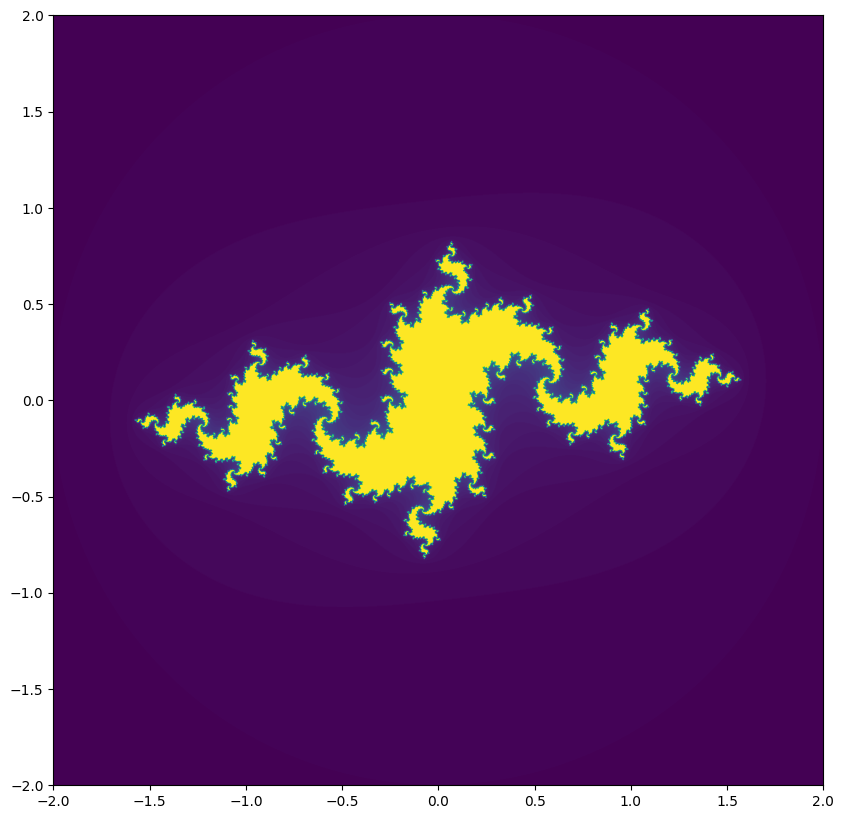

In [24]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
with cpu_timer():
    julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)

ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

### Elementwise Kernel

Using the `cupy.ElementwiseKernel` class it is easy to create GPU kernels by defining the computation that is going to be applied to each element of the input array(s).

In [21]:
julia_kernel = cp.ElementwiseKernel('float64 X, float64 Y, float64 cx, float64 cy, int32 itermax, float64 radius2',
                                    'int32 julia',
                                    f'''julia = 0;
                                    double x = X, y = Y;
                                    double xtemp;
                                    int nit = 0;
                                    while(x * x + y * y < radius2 && nit < itermax) {{
                                        xtemp = x * x - y * y + cx;
                                        y = 2.0 * x * y + cy;
                                        x = xtemp;
                                        nit += 1;
                                    }}
                                    julia = nit;''', 'julia_kernel')

Elapsed time: 55.71577453613281 ms


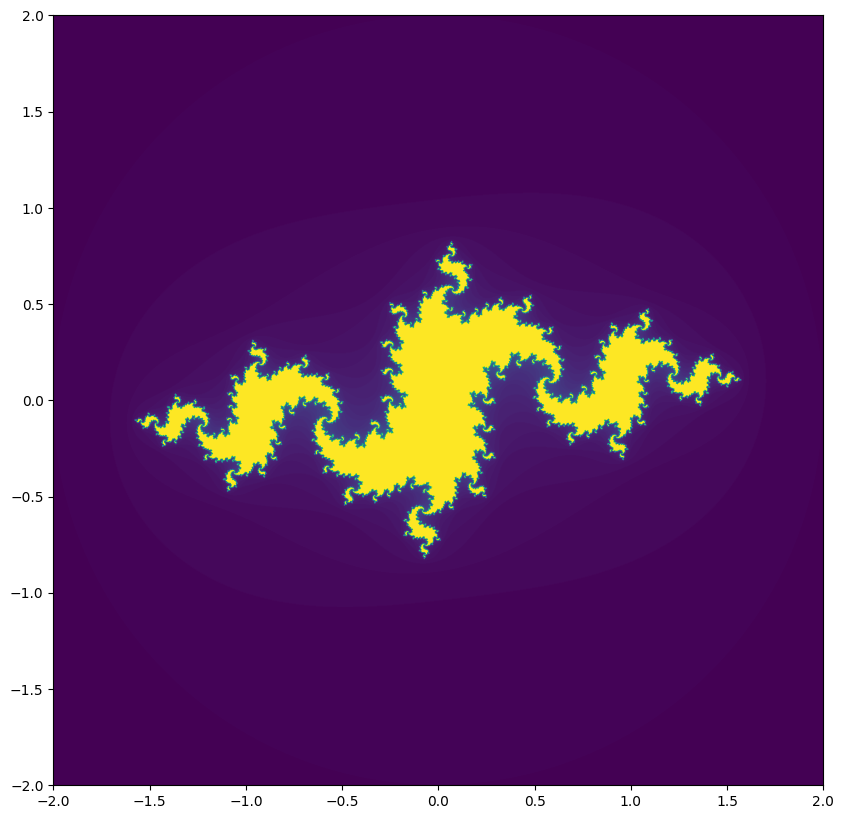

In [23]:
X, Y = cp.meshgrid(cp.linspace(-2.0 , 2.0, 5000), cp.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
c = -0.9 + 0.22143j
with cupy_timer():
    julia_gpu = julia_kernel(X, Y, c.real, c.imag, 100, 4.0)
    julia_array = julia_gpu.get()
ax.set_aspect('equal')
ax.imshow(julia_array, extent=[-2, 2, -2, 2]);

**Results**
> CPU-parrallelized : Elapsed time: 257.77157791890204 ms

> GPU-CuPy-based : Elapsed time: 55.71577453613281 ms\
    (without getting the matrix ack to the CPU) : Elapsed time: 55.71577453613281 ms

### Raw Kernel

It is possible to create raw CUDA kernels using the `cupy.RawKernel` class but the block and grid dimensions are not handled automatically.

In [25]:
julia_rawkernel = cp.RawKernel(r'''
        extern "C" 
        __global__ void julia_rawkernel(const double* X, const double* Y, const double cx,
                              const double cy, const int itermax, const int nx,
                              const int ny, const double radius, int* julia)  {
        int tidx = blockDim.x * blockIdx.x + threadIdx.x;
        int tidy = blockDim.y * blockIdx.y + threadIdx.y;
        int niter = 0;
        double tempx;
        if(tidx < nx && tidy < ny) 
        {
            int tid = tidy * nx + tidx;
            double x = X[tid], y = Y[tid];
            while((x * x + y * y) < (radius * radius) && niter < itermax) {
                tempx = x * x - y * y + cx;
                y = 2.0 * x * y + cy;
                x = tempx;
                niter +=1 ;
            }
            julia[tid] = niter;
        }
    }''', 'julia_rawkernel')

Elapsed time: 56.35670471191406 ms


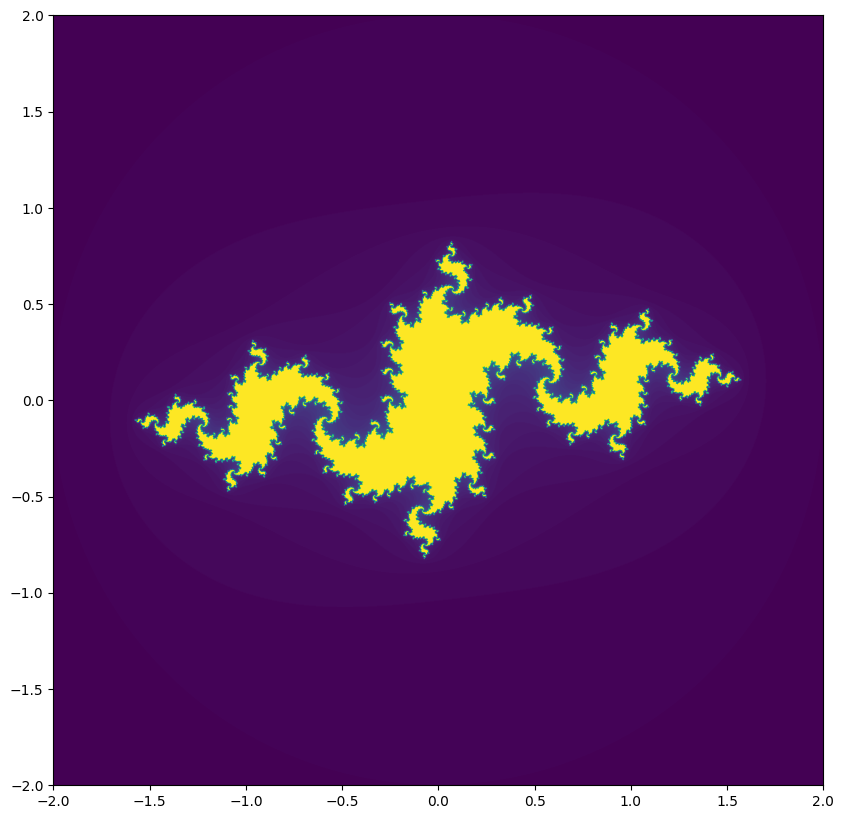

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
c = -0.9 + 0.22143j
threads_x = 32
threads_y = 32
x_points = 5000
y_points = 5000
x_blocks = (x_points - 1) // threads_x + 1 
y_blocks = (y_points - 1) // threads_y + 1
X_gpu, Y_gpu = cp.meshgrid(cp.linspace(-2.0 , 2.0, x_points), cp.linspace(-2.0, 2.0, y_points))
with cupy_timer():
    julia_gpu = cp.zeros_like(X_gpu, dtype=cp.int32)
    julia_rawkernel((x_blocks, y_blocks), (threads_x, threads_y), (X_gpu, Y_gpu, c.real, c.imag, 100, 
                    x_points, y_points, 2.0, julia_gpu))
    julia_array = julia_gpu.get()
ax.imshow(julia_array, extent=[-2, 2, -2, 2]);

<mark>Usually this means that you actually can performed an element-wise computation to solve your problem, however the more you get far away from an element-wise computation the more you need to think about the memory-structure and all the more complicated stuff</mark>

### Raw Kernel JIT (experimental)

In [28]:
from cupyx import jit

@jit.rawkernel()
def julia_kernel(X, Y, cx, cy, itermax, nx, ny, radius, julia):
    tidx = jit.blockDim.x * jit.blockIdx.x + jit.threadIdx.x
    tidy = jit.blockDim.y * jit.blockIdx.y + jit.threadIdx.y
    x = X[tidy, tidx]
    y = Y[tidy, tidx]   
    niter = 0
    if tidx < nx and tidy < ny:
        while (x * x + y * y) < radius * radius and niter < itermax:
            x, y = (x * x - y * y + cx), (2.0 * x * y + cy)
            niter += 1
            
        julia[tidy, tidx] = niter

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/hpcpy2023/lib/python3.9/site-packages/cupyx/jit/_interface.py:160: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Elapsed time: 56.20671844482422 ms


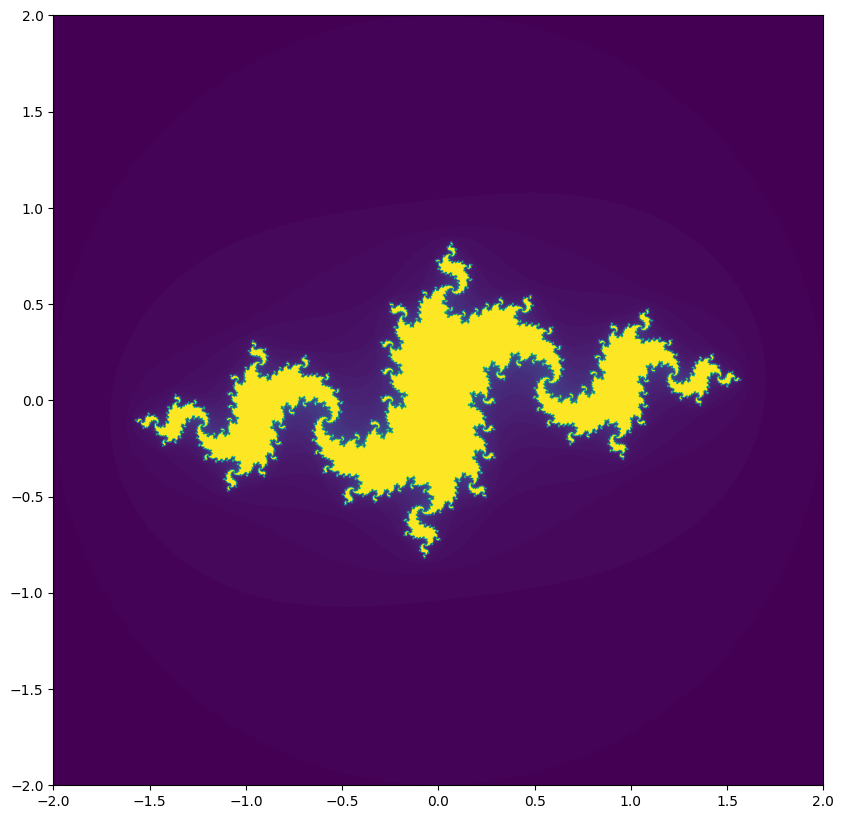

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
c = cp.complex64(-0.9 + 0.22143j)
threads_x = 32
threads_y = 32
x_points = 5000
y_points = 5000
x_blocks = (x_points - 1) // threads_x + 1 
y_blocks = (y_points - 1) // threads_y + 1
X_gpu, Y_gpu = cp.meshgrid(cp.linspace(-2.0 , 2.0, x_points), cp.linspace(-2.0, 2.0, y_points))
radius = cp.float64(2.0)
with cupy_timer():
    julia_gpu = cp.zeros_like(X_gpu, dtype=cp.int32)
    julia_kernel[(x_blocks, y_blocks), (threads_x, threads_y)](
        X_gpu, Y_gpu, c.real, c.imag, 100, x_points, y_points, radius, julia_gpu
    )
    julia_array = julia_gpu.get()
    
ax.imshow(julia_array, extent=[-2, 2, -2, 2]);

### Inspecting the source code of the kernel

In [31]:
print(julia_kernel.cached_code)


extern "C" __global__ void julia_kernel(CArray<double, 2, true, true> X, CArray<double, 2, true, true> Y, float cx, float cy, int itermax, int nx, int ny, double radius, CArray<int, 2, true, true> julia) {
  unsigned int tidx;
  unsigned int tidy;
  double x;
  double y;
  int niter;
  tidx = ((blockDim.x * blockIdx.x) + threadIdx.x);
  tidy = ((blockDim.y * blockIdx.y) + threadIdx.y);
  x = X._indexing(thrust::make_tuple(tidy, tidx));
  y = Y._indexing(thrust::make_tuple(tidy, tidx));
  niter = 0;
  if (((tidx < (unsigned int)(nx)) && (tidy < (unsigned int)(ny)))) {
    while (((((x * x) + (y * y)) < (radius * radius)) && (niter < itermax))) {
      {
        thrust::tuple<double, double> _temp0 = thrust::make_tuple((((x * x) - (y * y)) + (double)(cx)), (((2.0 * x) * y) + (double)(cy)));
        x = thrust::get<0>(_temp0);
        y = thrust::get<1>(_temp0);
      }
      niter = (niter + 1);
    }
    julia._indexing(thrust::make_tuple(tidy, tidx)) = niter;
  }
  else {
  }
}


## Kernel fusion

In [32]:
def sigmoid_cpu(x):
    return 1.0 / (1.0 + np.exp(-x))

sigmoid_kernel = cp.ElementwiseKernel(
    'float64 X',
    'float64 sigmoid',
    'sigmoid = 1.0 / (1.0 + exp(-X));', 
    'sigmoid_kernel')

@cp.fuse
def sigmoid_fused(x):
    return 1.0 / (1.0 + cp.exp(-x))

def sigmoid_gpu(x):
    return 1.0 / (1.0 + cp.exp(-x))

Sigmoid Cpu: Elapsed time: 268.72958010062575 ms
Sigmoid Gpu: Elapsed time: 1.2631360292434692 ms
Sigmoid Kernel: Elapsed time: 0.32368001341819763 ms
Sigmoid Fused: Elapsed time: 0.3314239978790283 ms


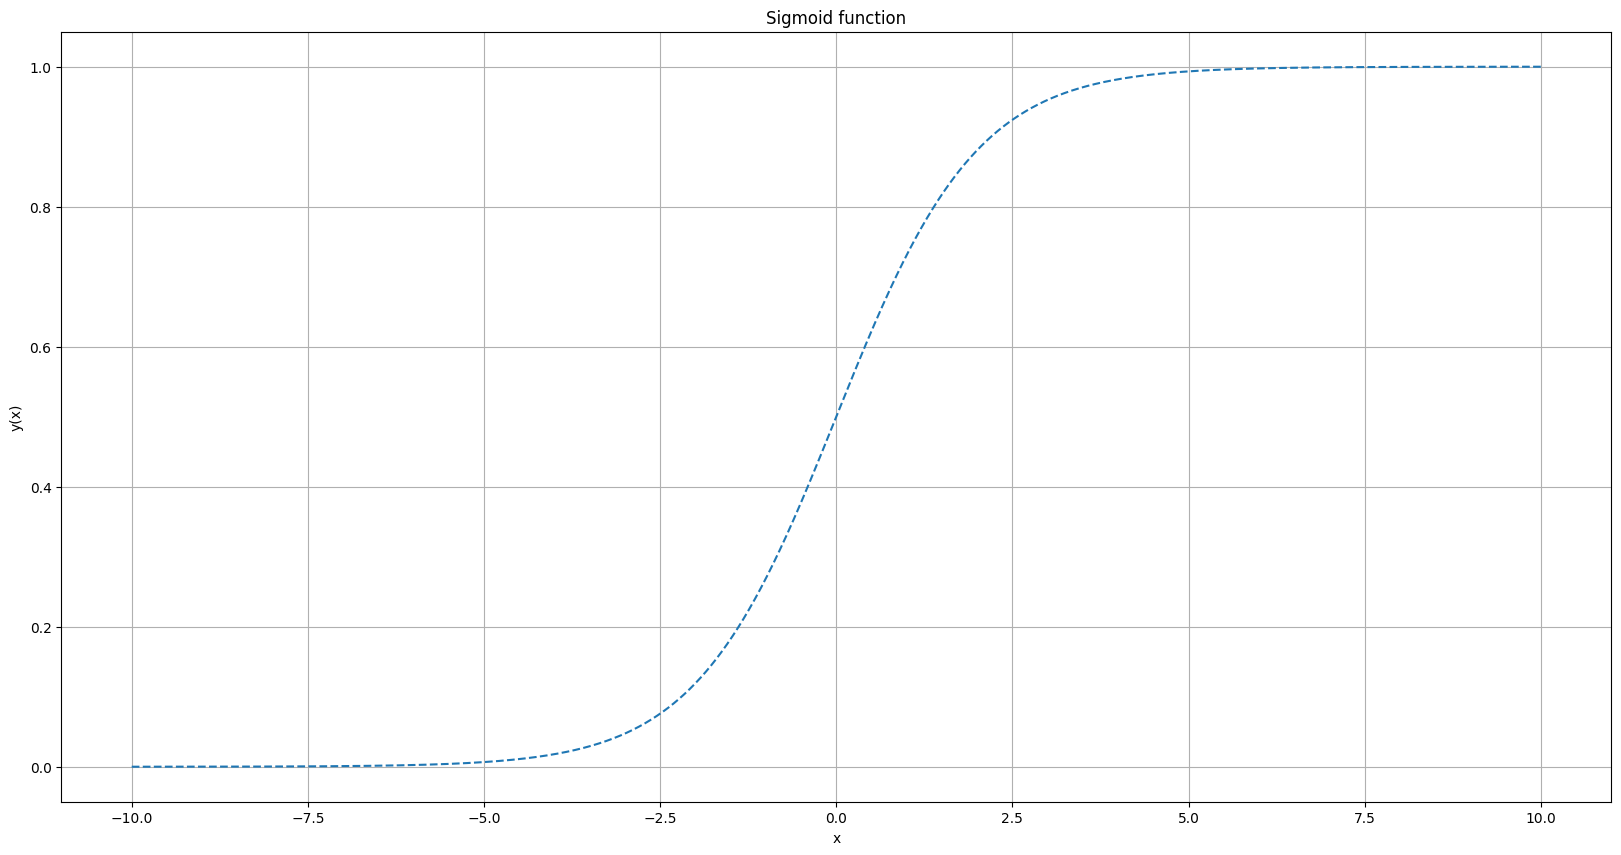

In [34]:
x_cpu = np.linspace(-10.0, 10.0, 10_000_000)
x_gpu = cp.array(x_cpu)

print('Sigmoid Cpu: ', end='')
with cpu_timer():
    s_cpu = sigmoid_cpu(x_cpu)
    
print('Sigmoid Gpu: ', end='')
with cupy_timer():
    s_gpu = sigmoid_gpu(x_gpu)
    
print('Sigmoid Kernel: ', end='')
with cupy_timer():
    s_gpu_kernel = sigmoid_kernel(x_gpu)
    
print('Sigmoid Fused: ', end='')
with cupy_timer():
    s_gpu_fused = sigmoid_fused(x_gpu)
    
assert(np.allclose(s_cpu, s_gpu.get()))
assert(cp.allclose(s_cpu, s_gpu_kernel))
assert(cp.allclose(s_cpu, s_gpu_fused))

plt.close('all')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(x_cpu, s_cpu, '--');
ax.set_title('Sigmoid function', )
ax.set_xlabel('x')
ax.set_ylabel('y(x)')
ax.grid('Both');

## CuPy Memory Pools 

In order to improve performance, CuPy uses a memory pool for memory allocations by default.

In [35]:
!nvidia-smi #

Thu Jun 22 15:51:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:02:00.0 Off |                    0 |
| N/A   27C    P0    31W / 250W |   2947MiB / 16280MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
%whos ndarray

Variable       Type       Data/Info
-----------------------------------
A              ndarray    1000x1000: 1000000 elems, type `float64`, 8000000 bytes (7.62939453125 Mb)
A_cpu          ndarray    10000x10000: 100000000 elems, type `float64`, 800000000 bytes (762.939453125 Mb)
A_gpu          ndarray    10000x10000: 100000000 elems, type `float64`, 800000000 bytes (762.939453125 Mb)
B              ndarray    1000x1000: 1000000 elems, type `float64`, 8000000 bytes (7.62939453125 Mb)
X              ndarray    5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
X_gpu          ndarray    5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
Y              ndarray    5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
Y_gpu          ndarray    5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
b_cpu          ndarray    10000: 10000 elems, type `float64`, 80000 bytes
b_gpu         

In [37]:
mempool = cp.get_default_memory_pool()

In [38]:
used_gbs = mempool.used_bytes() / 1024 ** 3
total_gbs = mempool.total_bytes() / 1024 ** 3
print(f'Memory pool uses: {used_gbs:.3f} out of {total_gbs:.3f} GB')

Memory pool uses: 1.915 out of 2.485 GB


In [40]:
mempool.free_all_blocks()

In [43]:
mempool.total_bytes() / 1024 ** 3

2.4627199172973633

<mark>memory pool can be cumbersome if you have very large/different allocations sizes however it's usually well behave as it ensures that some of the memory is always accessible, in particular when Python keeps allocating/deallocating memory</mark>